### **Imports**

In [59]:
from itu_helper import ItuHelper
from logger import Logger

from math import ceil

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np

### **Set the log level**

In [2]:
# Logger.set_log_level("info")
# Logger.set_log_level("error")
Logger.set_log_level("none")

### **Initilize the ITU Helper connection**

In [3]:
helper = ItuHelper()
helper.print_counts()

Total number of lessons: 3716
Total number of students enrolled: 136281
Total number of courses: 9518
Total number of buildings: 34


# **Plots**

## **1. Course Supply/Demand**


In [29]:
course_names = []
course_enrollments = []
course_capacities = []
course_fullness = []

for course in helper.courses:
    capacity, enrolled = course.get_total_capacity(), course.get_total_enrolled()
    if capacity is None or enrolled is None: continue

    course_names.append(course.code)
    course_enrollments.append(enrolled)
    course_capacities.append(capacity)
    course_fullness.append(enrolled / capacity if capacity > 0 else 0)

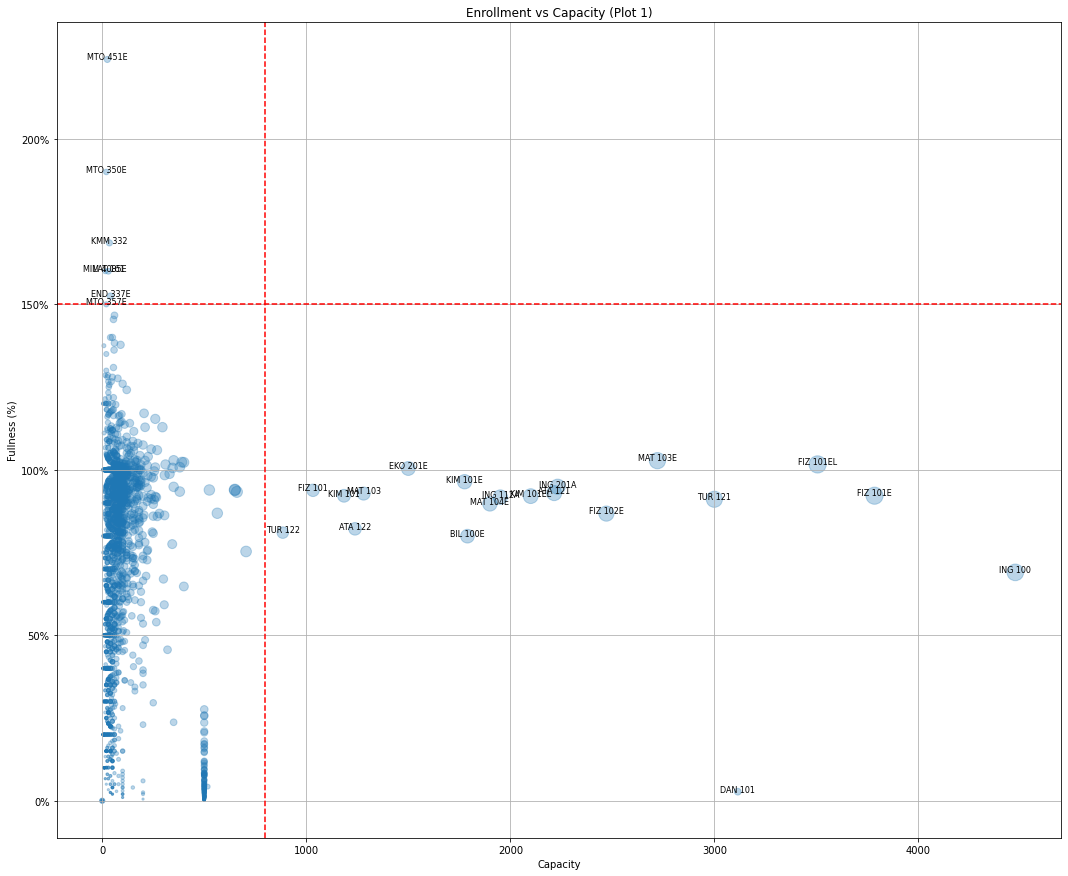

In [103]:
CAPACITY_THRESHOLD = 800
FULLNESS_THRESHOLD = 1.5

fig, ax = plt.subplots(figsize=(18, 15), facecolor="w")

scatter = ax.scatter(
    course_capacities, course_fullness,
    s=[x ** .5 * 5 for x in course_enrollments], alpha=.3, label=course_names
)

ax.set_title("Enrollment vs Capacity (Plot 1)")
ax.set_xlabel("Capacity")
ax.set_ylabel("Fullness (%)")

ax.axhline(y=FULLNESS_THRESHOLD, color='r', linestyle='--')
ax.axvline(x=CAPACITY_THRESHOLD, color='r', linestyle='--')
ax.grid(True)
ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Set y-axis formatter to display as percentage

# Add labels on each point
for i, txt in enumerate(course_names):
    # Skip the cluttered points
    if course_capacities[i] < CAPACITY_THRESHOLD and course_fullness[i] < FULLNESS_THRESHOLD: continue

    ax.annotate(txt, (course_capacities[i], course_fullness[i]), fontsize=8, ha='center')

plt.show()

### **Analysis for _Plot 1_**

This plot shows the distrbution of capacity and the fullness for each course. We can see the majority of the courses fall in the bottom-left region where capacity is below $800$ and fullness is below $150\%$.

#### Bottom-Left Region
It is hard to talk about the bottom-left region as it is really cluttered, we'll have to take a deeper look to find something from it.

#### Bottom-Right Region
In the bottom-right region we can see the courses with highest capacities, and, most of them are almost full, showing that there is enough lectures available for them, with few exceptions.
- We can decrease the capacity of _ING 100_ and _DAN101_.
- We need to increase the capacity for _MAT 103E_, _FIZ 101EL_ and _EKO 201E_

#### Top-Left Region
This region has courses with enrollments extremely about the capacity. We can see that these are mostly major-specific courses, which explains why the capacity is too low. We may need to increase their capacity by just opening one more lecture for each of them.

In [84]:
def filtered_enrollment_scatter(filter_func, ax, title: str, scale: float = 20, annotate: bool = False, fontsize: int=8):
    filtered_courses = [
        (name, capacity, fullness, enrollment)
        for name, capacity, fullness, enrollment in zip(course_names, course_capacities, course_fullness, course_enrollments) 
        if filter_func(capacity, fullness)
    ]

    filtered_names = [name for name, _, _, _ in filtered_courses]
    filtered_capacities = [capacity for _, capacity, _, _ in filtered_courses]
    filtered_enrollment = [enrollment for _, _, _, enrollment in filtered_courses]
    filtered_fullness = [fullness for _, _, fullness, _ in filtered_courses]

    ax.scatter(filtered_capacities, filtered_fullness, s=[x ** .5 * scale for x in filtered_enrollment], alpha=.3, label=course_names)
    
    ax.set_xlabel("Capacity")
    ax.set_ylabel("Fullness (%)")
    ax.set_title(title)
    ax.grid(True)
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))  # Set y-axis formatter to display as percentage
    
    # Add labels on each point
    if annotate:
        for i, txt in enumerate(filtered_names):
            ax.annotate(txt, (filtered_capacities[i], filtered_fullness[i]), fontsize=fontsize, ha='center')

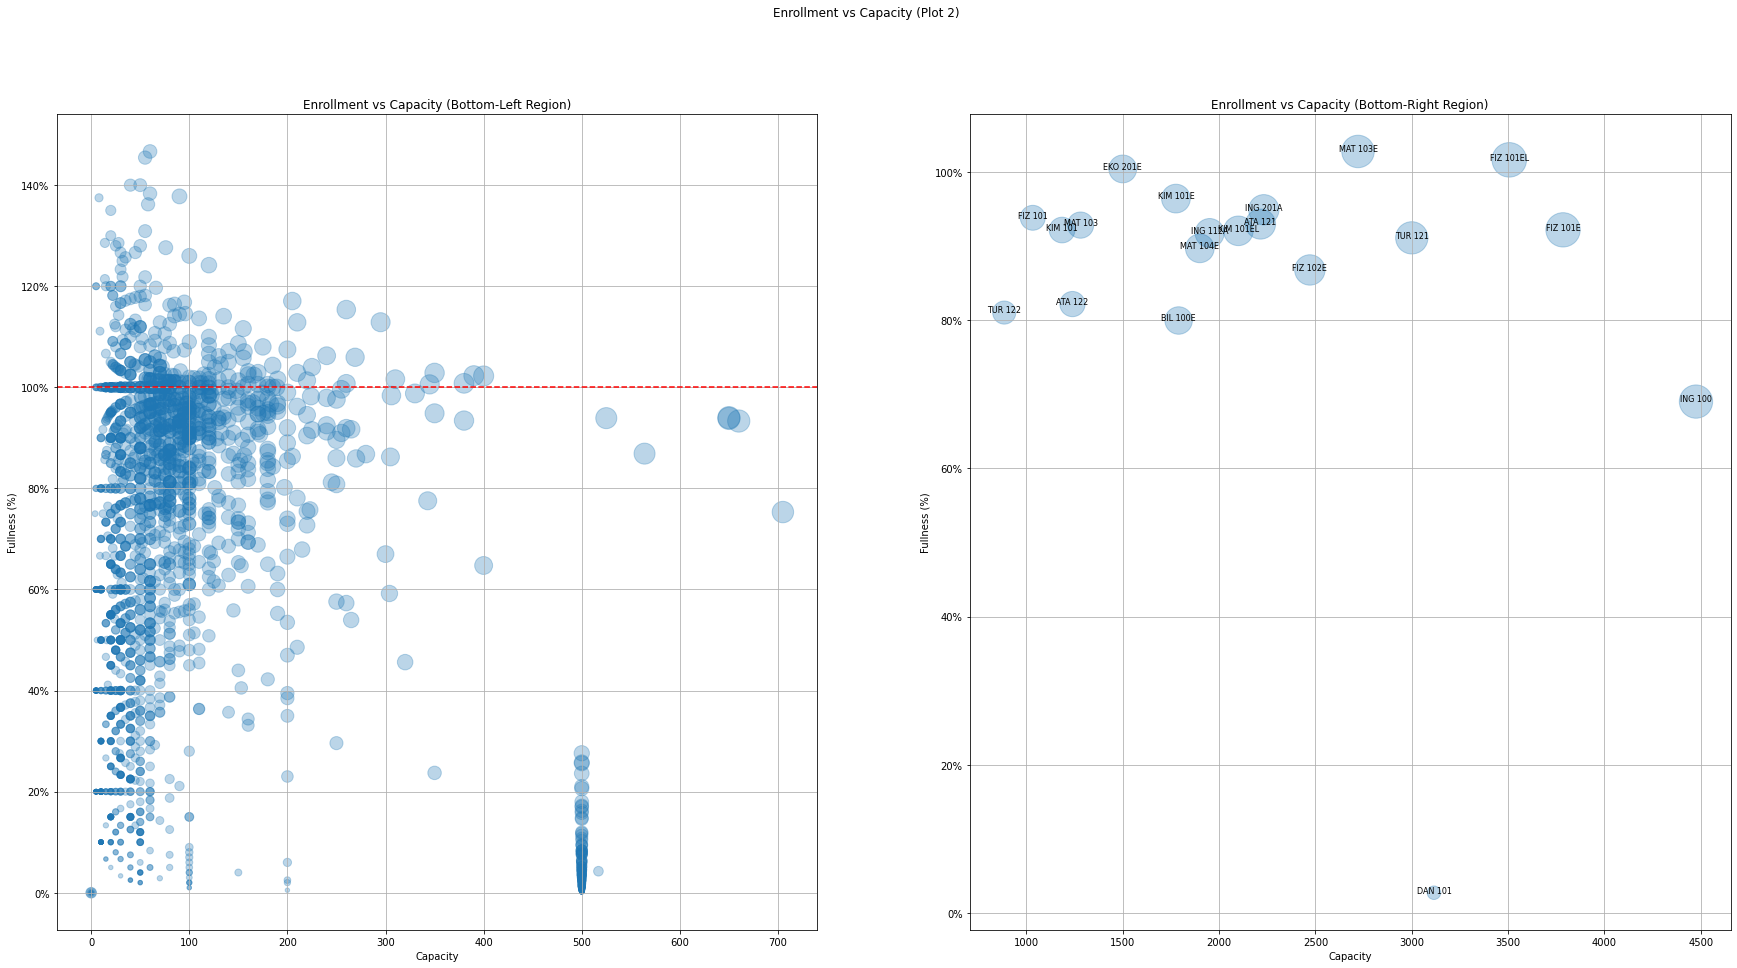

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15), facecolor="w")

filtered_enrollment_scatter(lambda c, f: c < CAPACITY_THRESHOLD and f < FULLNESS_THRESHOLD, axes[0], "Enrollment vs Capacity (Bottom-Left Region)", 20)
filtered_enrollment_scatter(lambda c, f: c > CAPACITY_THRESHOLD and f < FULLNESS_THRESHOLD, axes[1], "Enrollment vs Capacity (Bottom-Right Region)", 20, True)

axes[0].axhline(y=1, color='r', linestyle='--')
fig.suptitle("Enrollment vs Capacity (Plot 2)")

plt.show()

### **Analysis for _Plot 2_**

These two plots are follow-ups on _Plot 1_, the left one being the bottom-left region, and the right one being the bottom-right region.

#### Left Plot
We can see a really interesting spherical pattern occur in the bottom-left part of this plot. It is hard to explain what it is but looks interesting.

We can see there are a lot of courses with fullness between $100\%$ and $150\%$, which needs an increase in capacity. Only problem with this data is, when a course is full in capacity, university stuff can assign students to the already-full courses, which increase the capacity above $100\%$, however, in cases where the university stuff does not do that, they remain at $100\%$ capacity.

To determine which courses actually need an increase in capacity, we will have to skip the courses at $100\%$ capacity and start with a higher threashold of $120\%$ capacity.

#### Right Plot
Here, we can see the bottom-right part of _Plot 1_ more clearly, the analysis for this part will be the same as _Plot 1_'s analysis.
- We can decrease the capacity of _ING 100_ and _DAN101_.
- We need to increase the capacity for _MAT 103E_, _FIZ 101EL_ and _EKO 201E_

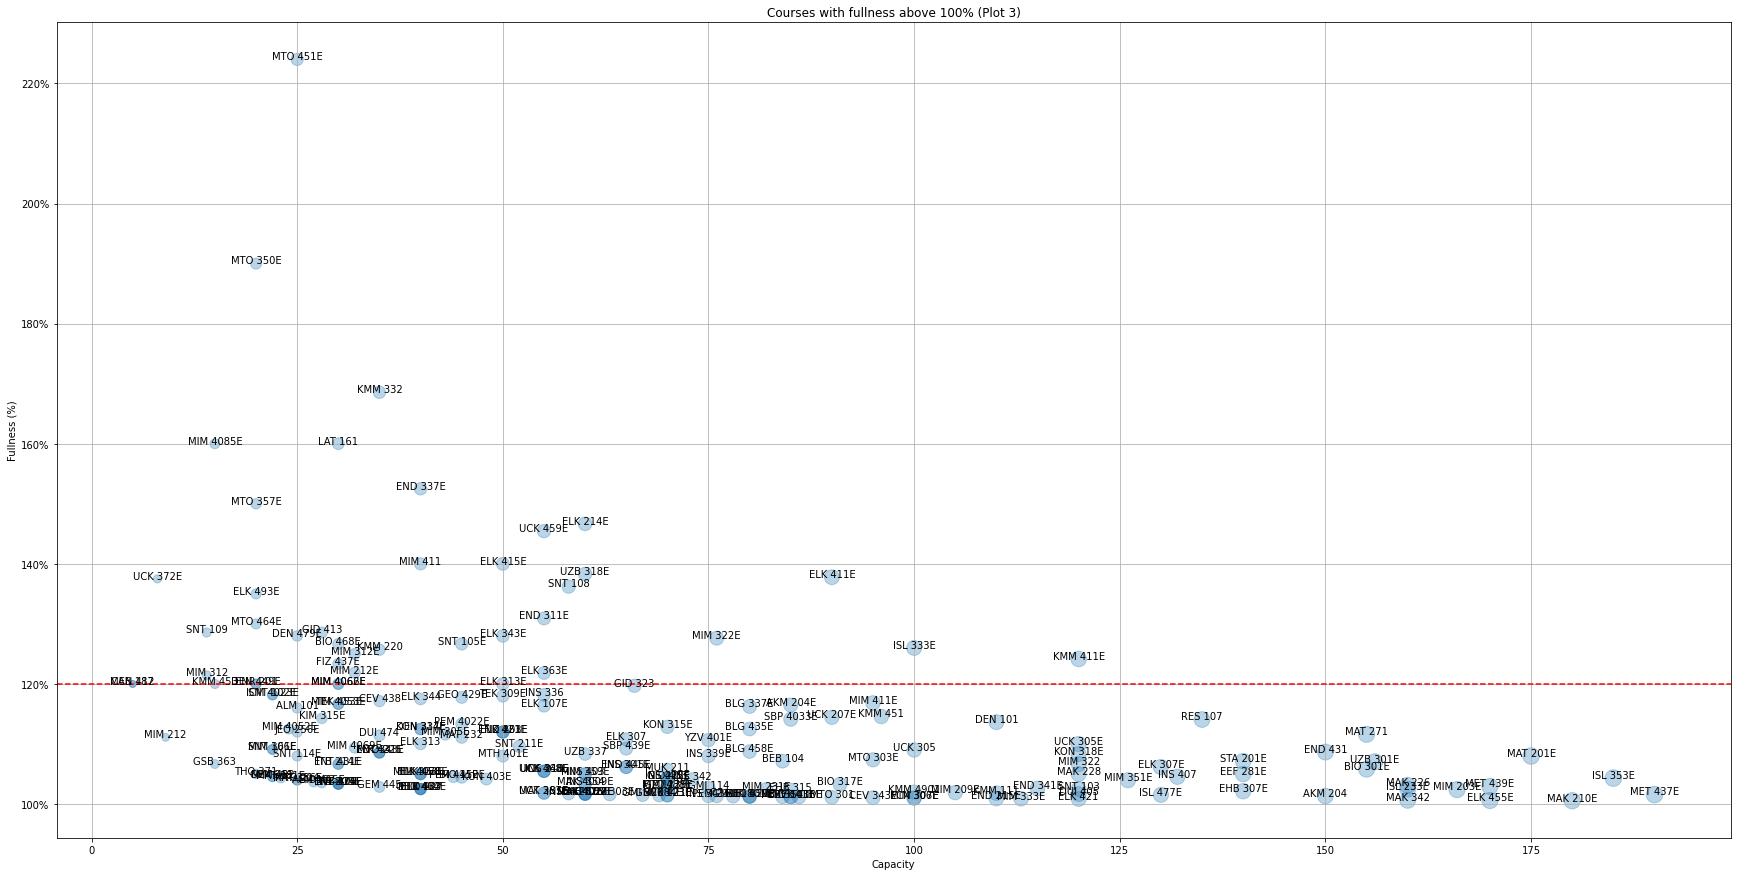

In [107]:
fig, ax = plt.subplots(figsize=(30, 15), facecolor="w")

filtered_enrollment_scatter(lambda c, f: c < 200 and f > 1, ax, "Courses with fullness above 100% (Plot 3)", 20, True, 10)
ax.axhline(y=1.2, color='r', linestyle='--')

plt.show()

### **Analysis for _Plot 3_**

This plot is the zoomed in version of the left plot in _Plot 2_. The courses above the red line needs a capacity increase, below are the top-20 of them:

1. MTO 451E : (224.00% full)		(Oceanography)
1. MTO 350E : (190.00% full)		(Air Pollution Fundamentals)
1. KMM 332  : (168.57% full)		(Ayırma İşlemleri)
1. LAT 161  : (160.00% full)		(English Composition)
1. MIM 4085E: (160.00% full)		(Byzantine Heritage inİstanbul)
1. END 337E : (152.50% full)		(Intr. to Operations Research)
1. MTO 357E : (150.00% full)		(Physics of Upper Atmosphere)
1. ELK 214E : (146.67% full)		(Fund.of Electr. Energy Conver.)
1. UCK 459E : (145.45% full)		(Helicopter Theory)
1. ELK 415E : (140.00% full)		(Digital Protection&amp;Signalling)
1. MIM 411  : (140.00% full)		(Mimari Proje VII)
1. UZB 318E : (138.33% full)		(Finite Element Method)
1. ELK 411E : (137.78% full)		(High Voltage Lab.)
1. UCK 372E : (137.50% full)		(Experimental Engineering)
1. SNT 108  : (136.21% full)		(Seramik)
1. ELK 493E : (135.00% full)		(Lighting Tech.&amp;Photometry Lab.)
1. END 311E : (130.91% full)		(Statistics)
1. MTO 464E : (130.00% full)		(Climate Change)
1. GID 413  : (128.57% full)		(Biyoteknoloji)
1. SNT 109  : (128.57% full)		(Kazı Resim (Gravür))

In [113]:
print("Top-20 courses that desperately need more capacity: ")
output_courses = []

for course in helper.courses:
    capacity, enrolled = course.get_total_capacity(), course.get_total_enrolled()
    if capacity is None or enrolled is None or capacity == 0: continue

    if capacity < 200 and enrolled / capacity > 1.2:
        output_courses.append([course, capacity, enrolled / capacity])

output_courses.sort(key=lambda x: x[2], reverse=True)
for o in output_courses[:20]:
    print(f"{o[0].code.ljust(9)}: ({o[2] * 100:.2f}% full)\t\t({o[0].name})")

Top-20 courses that desperately need more capacity: 
MTO 451E : (224.00% full)		(Oceanography)
MTO 350E : (190.00% full)		(Air Pollution Fundamentals)
KMM 332  : (168.57% full)		(Ayırma İşlemleri)
LAT 161  : (160.00% full)		(English Composition)
MIM 4085E: (160.00% full)		(	Byzantine Heritage inİstanbul)
END 337E : (152.50% full)		(Intr. to Operations Research)
MTO 357E : (150.00% full)		(Physics of Upper Atmosphere)
ELK 214E : (146.67% full)		(Fund.of Electr. Energy Conver.)
UCK 459E : (145.45% full)		(Helicopter Theory)
ELK 415E : (140.00% full)		(Digital Protection&amp;Signalling)
MIM 411  : (140.00% full)		(Mimari Proje VII)
UZB 318E : (138.33% full)		(Finite Element Method)
ELK 411E : (137.78% full)		(High Voltage Lab.)
UCK 372E : (137.50% full)		(Experimental Engineering)
SNT 108  : (136.21% full)		(Seramik)
ELK 493E : (135.00% full)		(Lighting Tech.&amp;Photometry Lab.)
END 311E : (130.91% full)		(Statistics)
MTO 464E : (130.00% full)		(Climate Change)
GID 413  : (128.57% full)	

## **2. Distribution of Enrolled Students**

In [115]:
weekday_counts_per_building = dict()
for l in helper.lessons:
    for building, day in zip(helper.get_building_from_lesson(l)[0], l.days):
        if day is None or "--" in day: continue # Skip lessons without a day
        if building is None or "--" in building: continue # Skip lessons without a building

        # Add the neccessary keys to the dict if they don't exist
        if building not in weekday_counts_per_building.keys():
            weekday_counts_per_building[building] = dict()

        if day not in weekday_counts_per_building[building].keys():
            weekday_counts_per_building[building][day] = 0
            
        # Add the enrolled student count to the array
        weekday_counts_per_building[building][day] += l.enrolled

# Remove the buildings that have no enrolled students
buildings_to_remove = []
for b in weekday_counts_per_building.keys():
    if sum(weekday_counts_per_building[b].values()) <= 0:
        buildings_to_remove.append(b)

for b in buildings_to_remove:
    weekday_counts_per_building.pop(b)

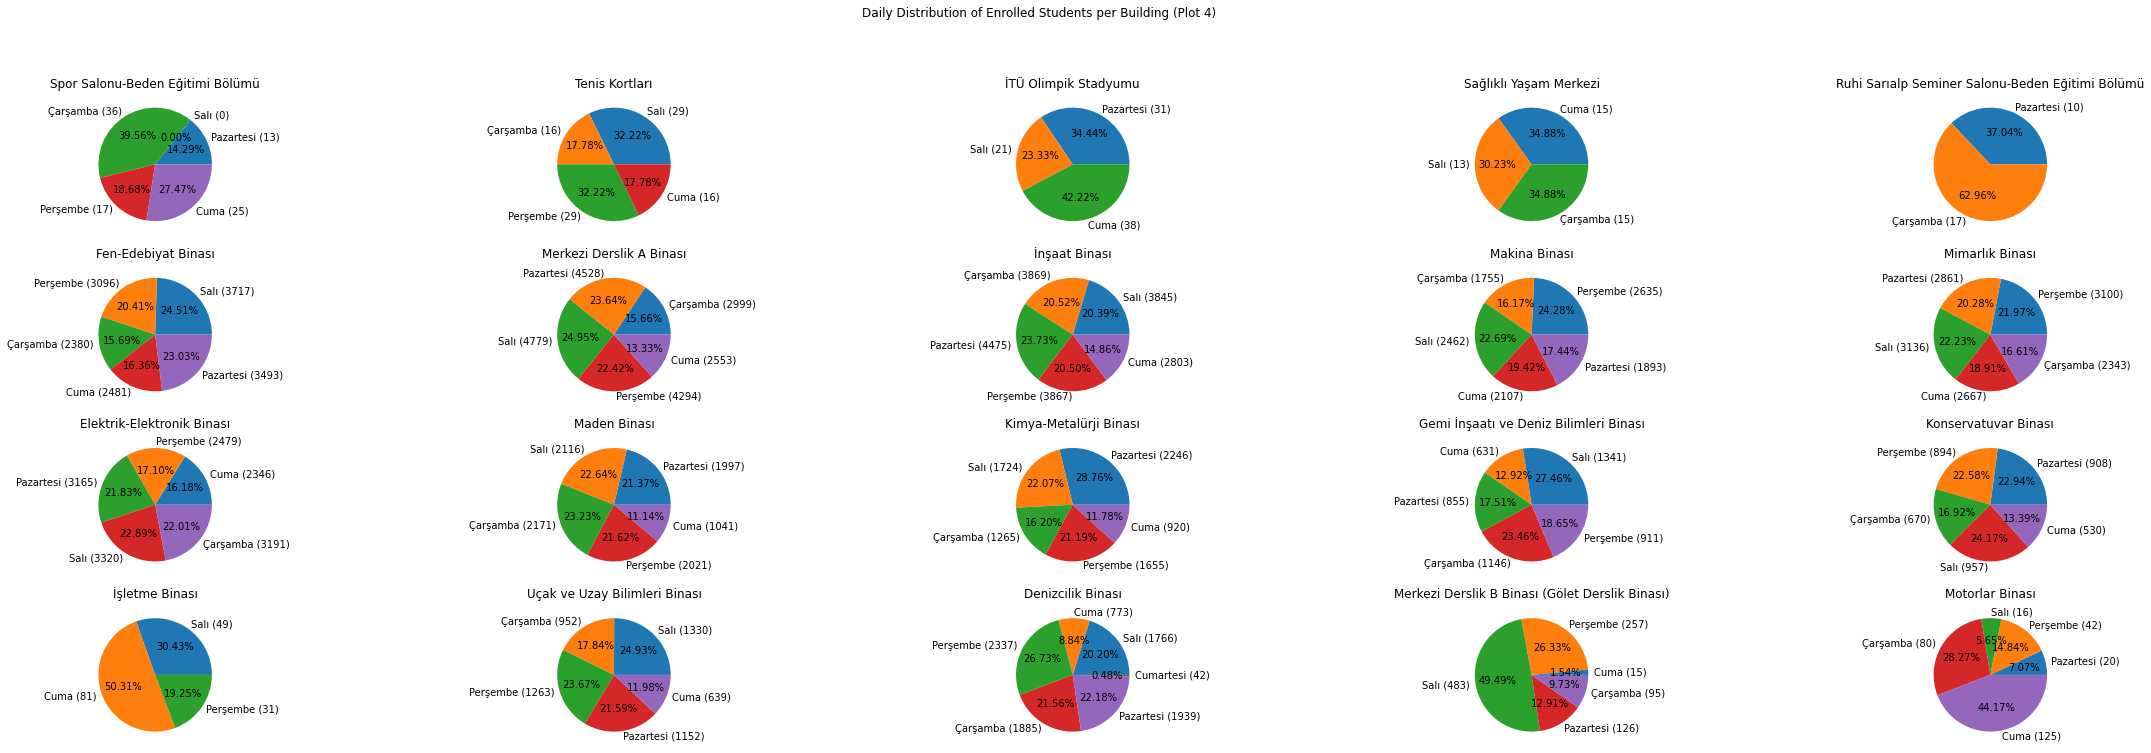

In [116]:
ROW_LENGTH = 5

fig, axs = plt.subplots(
    ceil(len(weekday_counts_per_building) // ROW_LENGTH), ROW_LENGTH,
    figsize=(37, 12), facecolor="w", gridspec_kw={'wspace': 1}
)

for i, (building, days) in enumerate(weekday_counts_per_building.items()):
    axs[i // ROW_LENGTH][i % ROW_LENGTH].pie(days.values(), labels=[f"{d.title()} ({v})" for d, v in days.items()], autopct=lambda pct: f"{pct:.2f}%")
    axs[i // ROW_LENGTH][i % ROW_LENGTH].set_title(building)

fig.suptitle("Daily Distribution of Enrolled Students per Building (Plot 4)")
plt.show()

### **Analysis for _Plot 4_**

In this plot, we have a pie chart for each building of the University, showing the number of enrolled students for each day of the week. Here, the data is a bit too complicated, yet we can still get some insights.

> :warning: If a student has multiple courses on the same day, there is no way to identify it so the data might include duplicated enrollment data for some students.

#### _Merkezi Derslik B Binası (Gölet Derslik Binası)_

We can see that _MED B_ is really busy on Tuesdays with almost $50\%$ of it's weekly capacity present. And then on Fridays, there is only $1.5\%$ of it's weekly capacity present. The courses could be adjusted to even out the distribution.

#### _İşletme Binası_ & _Motorlar Binası_

Again, there is a huge unevenness in these building's weekly distribution, but, as there aren't that many students, no adjustments are needed.

{'pazartesi': 29712, 'çarşamba': 24885, 'perşembe': 28928, 'cuma': 19806, 'salı': 31104, 'cumartesi': 42}


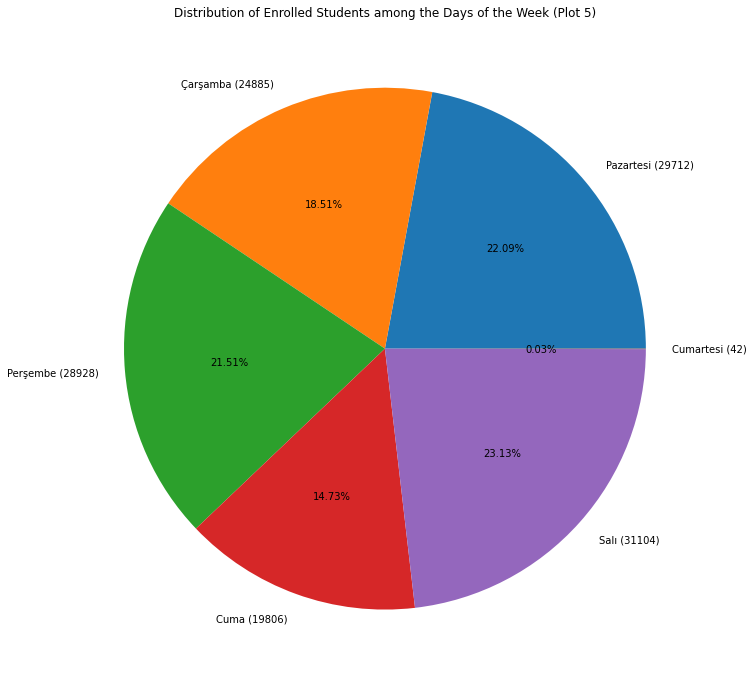

In [117]:
weekday_counts = dict()
for weekday_counts_of_building in weekday_counts_per_building.values():
    for day, enrolled in weekday_counts_of_building.items():
        if enrolled <= 0: continue
        if day not in weekday_counts.keys():
            weekday_counts[day] = 0
        
        weekday_counts[day] += enrolled

fig, ax = plt.subplots(
    figsize=(35, 12), facecolor="w", gridspec_kw={'wspace': 1}
)

print(weekday_counts)
ax.pie(weekday_counts.values(), labels=[f"{d.title()} ({v})" for d, v in weekday_counts.items()], autopct=lambda pct: f"{pct:.2f}%")
ax.set_title("Distribution of Enrolled Students among the Days of the Week (Plot 5)")

plt.show()

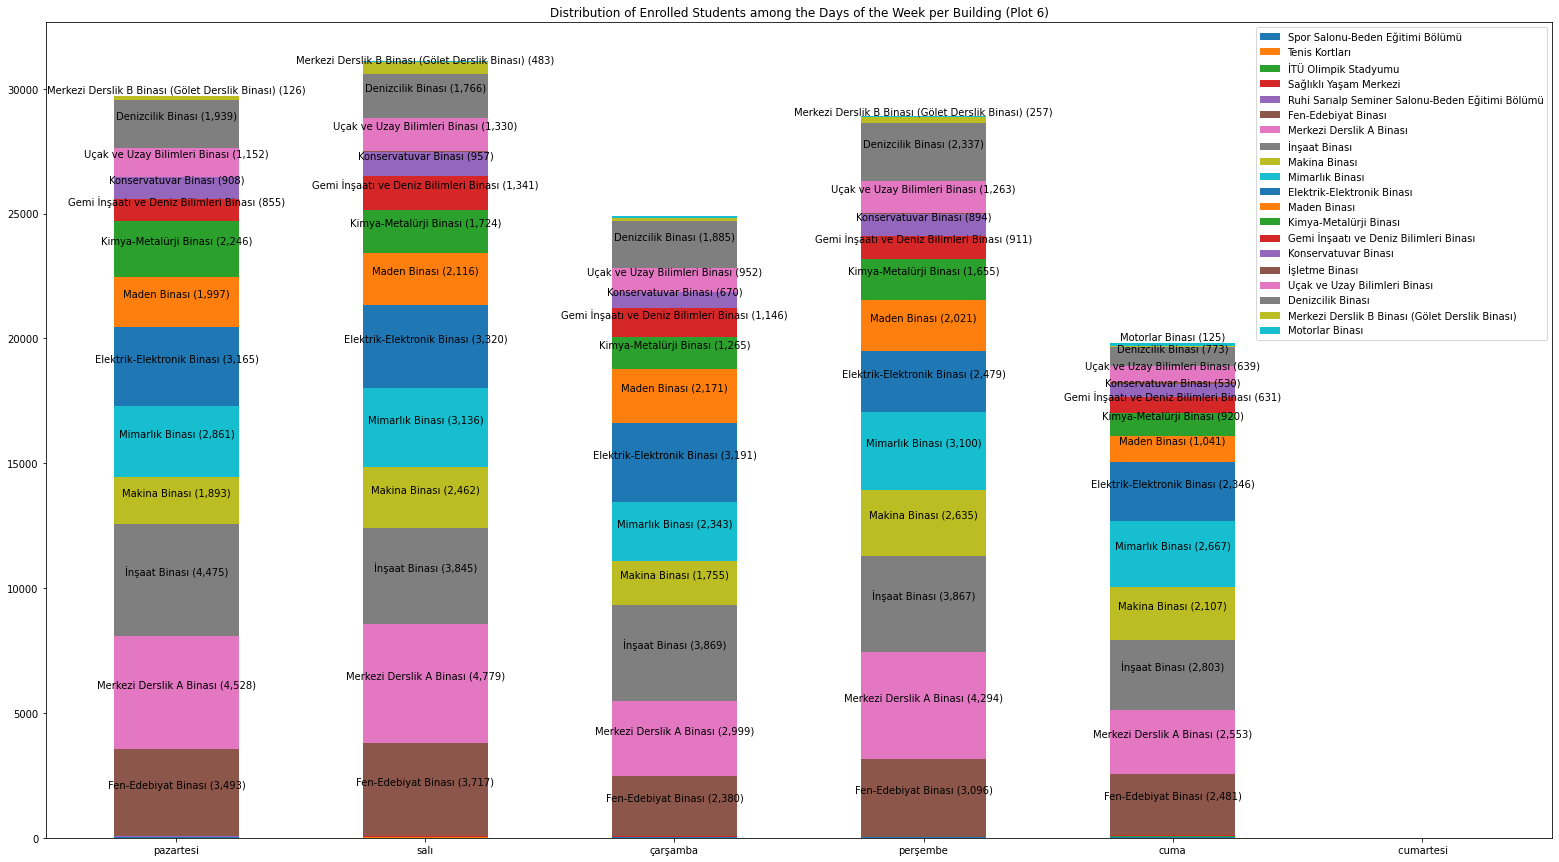

In [122]:

def get_days_axes(days: list[str]) -> tuple[list[int], list[str]]:
    day_names = ["pazartesi", "salı", "çarşamba", "perşembe", "cuma"," cumartesi"]
    output = [0] * 6
    for i, d in enumerate(day_names):
        if d in days.keys():
            output[i] = days[d]

    return day_names, output

fig, ax = plt.subplots(figsize=(27, 15), facecolor="w")
bottom = np.zeros(6)

for i, (building, days) in enumerate(weekday_counts_per_building.items()):
    x, y = get_days_axes(days)
    p = ax.bar(x, y, .5, label=building, bottom=bottom)
    
    # Add building names on the bars
    for i, rect in enumerate(p):
        height = rect.get_height()
        if height < 100: continue
        ax.annotate(f"{building} ({y[i]:,})", xy=(rect.get_x() + rect.get_width() / 2, height * .5 + bottom[i]), xytext=(0, 3),
                    textcoords="offset points", ha='center', va='bottom')

    bottom += y

ax.set_title("Distribution of Enrolled Students among the Days of the Week per Building (Plot 6)")
ax.legend(loc="upper right")

plt.show()

### **Analysis for _Plot 5_ & _Plot 6_**

We can see that the university is less busy on Fridays and Wednesdays.

**the top-5 busiests buildings:**

- Merkezi Derslik A Binası: $19,153$ students enrolled weekly
- İnşaat Binası: $18,859$ students enrolled weekly
- Fen-Edebiyat Binası: $15,167$ students enrolled weekly
- Elektrik-Elektronik Binası: $14,501$ students enrolled weekly
- Mimarlık Binası: $14,107$ students enrolled weekly

**the top-5 least busy buildings are:**

- Ruhi Sarıalp Seminer Salonu-Beden Eğitimi Bölümü: $27$ students enrolled weekly
- Sağlıklı Yaşam Merkezi: $43$ students enrolled weekly
- Tenis Kortları: $90$ students enrolled weekly
- İTÜ Olimpik Stadyumu: $90$ students enrolled weekly
- Spor Salonu-Beden Eğitimi Bölümü: $91$ students enrolled weekly

We can also calculate the average enrolled student count per day as $22,412.83$ and per building as $6,723.85$

In [123]:
# === BUSIEST BUILDINGS ===
busiest_buildings = sorted(weekday_counts_per_building.items(), key=lambda x: sum(x[1].values()), reverse=True)[:5]

print("Top 5 busiest buildings:")
for building, days in busiest_buildings:
    total_enrolled = sum(days.values())
    print(f"- {building}: {total_enrolled:,} students enrolled weekly")
    
# === LEAST BUSIEST BUILDINGS ===
least_busiest_buildings = sorted(weekday_counts_per_building.items(), key=lambda x: sum(x[1].values()))[:5]

print("Top 5 least busiest buildings:")
for building, days in least_busiest_buildings:
    total_enrolled = sum(days.values())
    print(f"- {building}: {total_enrolled:,} students enrolled weekly")

# === BUSIEST DAY ===
busiest_day = None
busiest_day_count = 0
for day, enrolled in weekday_counts.items():
    if enrolled > busiest_day_count:
        busiest_day = day
        busiest_day_count = enrolled

print(f"The busiest day is \"{busiest_day.title()}\" with {busiest_day_count:,} students enrolled")

# === LEAST BUSIEST DAY ===
least_busiest_day = None
least_busiest_day_count = 0
for day, enrolled in weekday_counts.items():
    if enrolled < least_busiest_day_count or least_busiest_day_count == 0:
        least_busiest_day = day
        least_busiest_day_count = enrolled

print(f"The least busiest day is \"{least_busiest_day.title()}\" with {least_busiest_day_count:,} students enrolled")

print("=" * 30)

# === AVERAGE STUDENT COUNT PER DAY ===
average_student_count_per_day = sum(weekday_counts.values()) / len(weekday_counts)
print(f"The average student count per day is {average_student_count_per_day:,.2f}")

# === AVERAGE STUDENT COUNT PER BUILDING ===
average_student_count_per_building = sum([sum(days.values()) for days in weekday_counts_per_building.values()]) / len(weekday_counts_per_building)
print(f"The average student count per building is {average_student_count_per_building:,.2f}")

# === BUILDINGS WITH LESS THAN AVERAGE STUDENT COUNT ===
buildings_with_less_than_average_student_count = []
for building, days in weekday_counts_per_building.items():
    total = sum(days.values())
    if total < average_student_count_per_building:
        buildings_with_less_than_average_student_count.append((building, total))

print("=" * 30)

print(f"The buildings with less than average student count are:")
for b, t in buildings_with_less_than_average_student_count:
    print(f"- {b} ({t:,} enrolled weekly)")

Top 5 busiest buildings:
- Merkezi Derslik A Binası: 19,153 students enrolled weekly
- İnşaat Binası: 18,859 students enrolled weekly
- Fen-Edebiyat Binası: 15,167 students enrolled weekly
- Elektrik-Elektronik Binası: 14,501 students enrolled weekly
- Mimarlık Binası: 14,107 students enrolled weekly
Top 5 least busiest buildings:
- Ruhi Sarıalp Seminer Salonu-Beden Eğitimi Bölümü: 27 students enrolled weekly
- Sağlıklı Yaşam Merkezi: 43 students enrolled weekly
- Tenis Kortları: 90 students enrolled weekly
- İTÜ Olimpik Stadyumu: 90 students enrolled weekly
- Spor Salonu-Beden Eğitimi Bölümü: 91 students enrolled weekly
The busiest day is "Salı" with 31,104 students enrolled
The least busiest day is "Cumartesi" with 42 students enrolled
The average student count per day is 22,412.83
The average student count per building is 6,723.85
The buildings with less than average student count are:
- Spor Salonu-Beden Eğitimi Bölümü (91 enrolled weekly)
- Tenis Kortları (90 enrolled weekly)
- İT